In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS,
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + RESEARCHER_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  2. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool                                   │
│  4. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  5. **Verify**: Read `/research_request.md` to confirm you've addressed all aspects of the original question    │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                                                                                        │
│  Simply list items with details - no introduction needed:                                                       │
│  1. Item 1 with explanation                                                                                     │
│  2. Item 2 with explanation                                                                                     │
│  3. Item 3 with explanation                           

### Create the agent

Now, we create our deepagent with these components. 

In [7]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI

# Model Claude 4.5
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Model Gemini 3 
model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

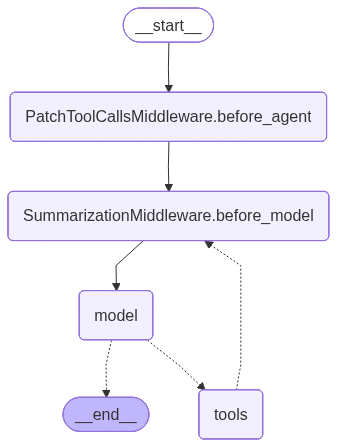

In [8]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [34]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "research context engineering approaches used to build AI agents",                                 │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: a4a0832d-9bae-487c-b52f-164d0b47afdc                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research core concepts and definitions of context engineering in AI agents",                  │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research structural techniques for context management (e.g., RAG, Long-term memory systems,   │
│ Sliding windows)",                                                                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research context optimization and compression techniques (e.g., Prompt compression,           │
│ Summarization, Token selection)",                                                                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write final report on context engineering approaches",                                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 29e25aca-85a1-41f9-9149-4304f30e5fa5                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research core concepts and definitions of context engineering in AI agents', │
│ 'status': 'in_progress'}, {'content': 'Research structural techniques for context management (e.g., RAG,        │
│ Long-term memory systems, Sliding windows)', 'status': 'pending'}, {'content': 'Research context optimization   │
│ and compression techniques (e.g., Prompt compression, Summarization, Token selection)', 'status': 'pending'},   │
│ {'content': 'Write final report on context engineering approaches', 'status': 'pending'}]                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research the core concepts and definitions of 'context engineering' specifically for AI       │
│ agents. \nFind out:\n1. What is context engineering?\n2. Why is it critical for AI agents?\n3. Key principles   │
│ (e.g. relevance, coherence, token limits).\n4. Distinctions between context engineering and prompt              │
│ engineering.\n\nReturn a summary of findings with sources."                                                     │
│ }                                                                                                               │
│    ID: 60ae692d-a760-4254-8819-d3541d2b6456                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research structural techniques for context management in AI agents.\nFocus on:\n1.            │
│ Retrieval-Augmented Generation (RAG) patterns for context injection.\n2. Memory architectures (Short-term vs    │
│ Long-term, Vector databases).\n3. Context window management strategies (Sliding windows, Hierarchical           │
│ context).\n4. Dynamic context selection methods.\n\nReturn a summary of findings with sources."                 │
│ }                                                                                                               │
│    ID: 8ce46bb7-c73d-47ff-a20d-ff7add14a95a                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research context optimization and compression techniques for AI agents.\nFocus on:\n1.        │
│ Summarization techniques to reduce context size.\n2. Prompt compression algorithms (e.g., selective context,    │
│ LLMLingua).\n3. Token selection/pruning strategies.\n4. Any specific tools or libraries known for this (e.g.    │
│ LangChain's approaches).\n\nReturn a summary of findings with sources."                                         │
│ }                                                                                                               │
│    ID: ae5f9ef0-1ebb-48dc-ae07-438f9205f022                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on the research, here is a summary of the core concepts of **Context Engineering** for AI agents.         │
│                                                                                                                 │
│ ### 1. What is Context Engineering?                                                                             │
│ **Context Engineering** is the technical practice of designing, curating, and managing the total information    │
│ state (the "context") provided to an AI agent during its operation. Unlike simple prompting, which focuses on a │
│ single input instruction, context engineering is a **systemic and iterative process** that determines *what*    │
│ information an agent perceives at every step of a workflow [1].                                                 │
│                                                                                                                 │
│ It involves configuring the optimal set of tokens—including system instructions, tool definitions, conversation │
│ history, and external data—to ensure the model behaves reliably over time. Ideally, it answers the question:    │
│ *"What configuration of context is most likely to generate the model's desired behavior?"* [2]                  │
│                                                                                                                 │
│ ### 2. Why is it Critical for AI Agents?                                                                        │
│ Context engineering is essential for shifting from simple chatbots to autonomous agents that perform complex,   │
│ multi-step tasks.                                                                                               │
│ *   **Combating "Context Rot":** As the amount of information (tokens) in a context window increases, a model’s │
│ ability to retrieve specific details ("needle-in-a-haystack") often degrades. This is due to the **attention    │
│ scarcity** inherent in transformer architectures (where computational complexity is $N^2$ relative to context   │
│ length) [1].                                                                                                    │
│ *   **Enabling Long-Horizon Tasks:** Agents working on tasks spanning hours or days (e.g., coding, research)    │
│ accumulate massive amounts of history. Without engineering strategies to manage this, the context window fills  │
│ up, leading to lost instructions, confusion, or crashed sessions [1].                                           │
│ *   **Reliability & Cost:** Providing "just enough" high-signal context reduces hallucination risks and         │
│ operational costs associated with processing unnecessary tokens.                                                │
│                                                                                                                 │
│ ### 3. Key Principles of Context Engineering                                                                    │
│ Effective context engineering relies on providing the **smallest possible set of high-signal tokens**.          │
│                                                                                                                 │
│ *   **Relevance (Signal-to-Noise Ratio):**                                                                      │
│     *   **Just-in-Time Retrieval:** Instead of dumping all files into the context (traditional RAG), agents     │
│ should be equipped with tools (like `grep` or `ls`) to autonomously "pull" only the information they need when  │
│ they need it [2].                                                                                               │
│     *   **The "Right Altitude":** System prompts should avoid being too brittle (hardcoded logic) or too vague. │
│ They should provide flexible heuristics and distinct se

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Research into structural techniques for context management in AI agents reveals a shift from static retrieval   │
│ to dynamic, modular architectures that mimic human cognitive processes.                                         │
│                                                                                                                 │
│ ### 1. Retrieval-Augmented Generation (RAG) Patterns                                                            │
│ Modern RAG has evolved beyond simple vector search into **Modular RAG** architectures [1].                      │
│ *   **Pre-Retrieval**: Techniques include **Query Rewriting** (transforming user input into optimal search      │
│ queries) and **Query Expansion** (generating multiple sub-queries to broaden search coverage).                  │
│ *   **Post-Retrieval**: Retrieved contexts undergo **Re-ranking** (scoring by relevance) and **Pruning**        │
│ (removing redundant information) before reaching the LLM.                                                       │
│ *   **GraphRAG**: A structural technique that builds a knowledge graph from the corpus. It uses community       │
│ detection to create hierarchical summaries, allowing the agent to answer "global" questions (e.g., "What are    │
│ the main themes?") that standard vector search misses [2].                                                      │
│ *   **Agentic RAG**: Treats retrieval as a multi-step reasoning process where an agent actively critiques       │
│ retrieved data and iteratively queries until it has sufficient context [1].                                     │
│                                                                                                                 │
│ ### 2. Memory Architectures                                                                                     │
│ Agent memory is structurally divided to balance immediate reasoning with long-term retention [3].               │
│ *   **Short-Term Memory (STM)**: Resides in the LLM's **context window**. It acts as a "working memory" for the │
│ current session, often managed by summary buffers to prevent overflow.                                          │
│ *   **Long-Term Memory (LTM)**: Implemented via **Vector Databases** (for semantic search) and **Knowledge      │
│ Graphs** (for structured relationships).                                                                        │
│ *   **Episodic Memory**: Stores specific past experiences (sequences of actions/results) to enable few-shot     │
│ learning from history.                                                                                          │
│ *   **Procedural Memory**: Stores "skills" or "how-to" knowledge, often encoded as static prompt libraries or   │
│ code tools the agent can invoke.                                                                                │
│ *   **MemGPT Pattern**: An architecture where the LLM acts as an operating system, autonomously managing its    │
│ own memory by deciding when to move information between context (STM) and storage (LTM) [3].                    │
│                                                                                                                 │
│ ### 3. Context Window Management Strategies                                                                     │
│ Techniques to maximize the utility of limited context windows include:                                          │
│ *   **Sliding Windows**: A standard technique where long documents are broken into overlapping chunks (e.g.,    │
│ 512 tokens with 128-token overlap) to ensure no context is lost at boundaries during processing [4].            │
│ *   **Hierarchical Context**: Strategies like **GraphRAG** or **Fusion-in-Decoder (FiD)** process information   │
│ at multiple levels of abstraction. Documents are first 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Research into context optimization reveals a multi-layered approach ranging from high-level architectural       │
│ strategies (summarization) to low-level token manipulation (pruning). Below is a summary of findings on         │
│ techniques for reducing context size and optimizing AI agent performance.                                       │
│                                                                                                                 │
│ ### 1. Summarization Techniques                                                                                 │
│ Summarization is the most common high-level strategy for managing long conversation histories.                  │
│                                                                                                                 │
│ *   **Rolling Summaries (Incremental Compression):** Instead of retaining the entire history, the system        │
│ periodically "melts down" previous turns into a concise summary. This maintains continuity but may lose         │
│ specific nuances over time [1].                                                                                 │
│ *   **Hybrid Memory:** A robust approach that combines different memory types. It typically preserves "pinned"  │
│ key messages (like the system prompt or initial user instructions) verbatim while compressing intermediate      │
│ messages into summaries. This ensures critical instructions are never lost to compression artifacts [1].        │
│ *   **Externalized Memory:** For agents requiring long-term recall, context is offloaded to a vector database.  │
│ Relevant information is retrieved semantically (RAG) rather than keeping everything in the active context       │
│ window [1].                                                                                                     │
│                                                                                                                 │
│ ### 2. Prompt Compression Algorithms                                                                            │
│ These algorithms aim to reduce the number of tokens sent to the model without losing semantic meaning, often by │
│ analyzing the information density of the text.                                                                  │
│                                                                                                                 │
│ *   **Selective Context:** This method uses a smaller base language model (like GPT-2) to calculate the         │
│ "self-information" (perplexity) of lexical units (tokens, phrases, or sentences). Content with low              │
│ self-information—meaning it is predictable or redundant—is pruned. This can reduce context usage significantly  │
│ while maintaining performance on tasks like summarization and QA [2].                                           │
│ *   **LLMLingua:** A coarse-to-fine compression framework. It employs a "budget controller" to dynamically      │
│ allocate different compression ratios to different parts of the prompt (e.g., compressing few-shot              │
│ demonstrations aggressively while preserving the user's specific instruction). It also aligns the distribution  │
│ between the small compression model and the target LLM to prevent performance degradation [3].                  │
│                                                                                                                 │
│ ### 3. Token Selection & Pruning Strategies                                                                     │
│ Token pruning operates at a lower level, often during the inference process itself.                             │
│                                                                                                                 │
│ *   **Dynamic Token Pruning (e.g., LazyLLM):** Unlike s

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Context Engineering Approaches for Building AI Agents\n\nContext Engineering is the systematic  │
│ practice of designing, curating, and managing the information state (context) provided to an AI agent. Unlike   │
│ prompt engineering, which focuses on crafting static instructions, context engineering is an architectural      │
│ discipline concerned with the dynamic flow of information\u2014history, tools, and data\u2014to ensure agent    │
│ reliability over long-horizon tasks.\n\n## Core Principles\n\nEffective context engineering aims to solve       │
│ \"context rot\" and attention scarcity by optimizing the signal-to-noise ratio within the agent's limited       │
│ context window.\n\n*   **Dynamic State Management**: Moving beyond static prompts to dynamic environments where │
│ context is retrieved, pruned, and updated in real-time [1].\n*   **Signal Maximization**: Prioritizing          │
│ high-value tokens. As context length increases, a model's ability to retrieve specific details decreases; thus, │
│ reducing noise is critical for accuracy [2].\n*   **Distinction from Prompt Engineering**:\n    *   *Prompt     │
│ Engineering*: \"How do I ask this question to get the best answer?\"\n    *   *Context Engineering*: \"How do I │
│ architect the agent's memory and environment so it has the right information to answer any question?\"          │
│ [1].\n\n## Structural Approaches\n\n### 1. Retrieval-Augmented Generation (RAG) Patterns\nModern agents use     │
│ advanced RAG patterns to inject context dynamically rather than stuffing the window.\n*   **Agentic RAG**: A    │
│ multi-step process where the agent actively critiques retrieved data and iteratively queries until it has       │
│ sufficient context, rather than accepting the first retrieval result [3].\n*   **GraphRAG**: Uses knowledge     │
│ graphs to structure data hierarchically. This allows agents to answer \"global\" questions (e.g., \"What are    │
│ the main themes in this dataset?\") by traversing community summaries, a capability often missing in standard   │
│ vector search [4].\n*   **Modular RAG**: Incorporates pre-retrieval steps (query rewriting/expansion) and       │
│ post-retrieval steps (re-ranking/pruning) to refine the context before it reaches the LLM [3].\n\n### 2. Memory │
│ Architectures\nTo handle long-running tasks, agents employ split-memory architectures mimicking human           │
│ cognition.\n*   **MemGPT Pattern**: Treats the LLM as an operating system that manages its own memory           │
│ hierarchy. It explicitly moves information between \"active context\" (RAM) and \"archival storage\"            │
│ (Disk/Vector DB) to manage limited context windows autonomously [5].\n*   **Short-Term vs. Long-Term**:\n    *  │
│ *Short-Term (STM)*: The immediate context window, often managed with sliding windows or rolling summaries.\n    │
│ *   *Long-Term (LTM)*: Vector databases (semantic recall) and SQL databases (structured recall) for infinite    │
│ storage [5].\n*   **Episodic Memory**: Storing sequences of past actions and results to enable few-shot         │
│ learning from previous experiences.\n\n### 3. Context Management Strategies\n*   **Sliding Windows**: Breaking  │
│ long documents into overlapping chunks (e.g., 512 tokens with 128-token overlap) to process streams of data     │
│ without losing boundary context [6].\n*   **Hierarchical Context (Fusion-in-Decoder)**: Processing documents at │
│ multiple levels of abstraction. Agents first scan high-l

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research core concepts and definitions of context engineering in AI agents",                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research structural techniques for context management (e.g., RAG, Long-term memory systems,   │
│ Sliding windows)",                                                                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research context optimization and compression techniques (e.g., Prompt compression,           │
│ Summarization, Token selection)",                                                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write final report on context engineering approaches",                                        │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 41f5ec4f-9cc1-42e5-bfe5-578e82689f9d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research core concepts and definitions of context engineering in AI agents', │
│ 'status': 'completed'}, {'content': 'Research structural techniques for context management (e.g., RAG,          │
│ Long-term memory systems, Sliding windows)', 'status': 'completed'}, {'content': 'Research context optimization │
│ and compression techniques (e.g., Prompt compression, Summarization, Token selection)', 'status': 'completed'}, │
│ {'content': 'Write final report on context engineering approaches', 'status': 'completed'}]                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The research on context engineering approaches for AI agents is complete. I have compiled a detailed report     │
│ covering core principles, structural architectures (like RAG and Memory Systems), and optimization techniques   │
│ (such as compression and pruning).                                                                              │
│                                                                                                                 │
│ ### Key Findings                                                                                                │
│ *   **Definition**: Context engineering is the architectural practice of managing the agent's information       │
│ environment (history, tools, data) to ensure reliability, as opposed to just crafting static prompts.           │
│ *   **Structural Techniques**:                                                                                  │
│     *   **RAG Patterns**: GraphRAG and Agentic RAG allow for dynamic and hierarchical information retrieval.    │
│     *   **Memory**: "MemGPT" style architectures that manage Short-Term vs. Long-Term memory autonomously.      │
│ *   **Optimization**:                                                                                           │
│     *   **Compression**: Algorithms like **LLMLingua** and **Selective Context** to reduce token usage while    │
│ preserving meaning.                                                                                             │
│     *   **Summarization**: "Rolling summaries" and "Hybrid memory" to balance history retention with context    │
│ limits.                                                                                                         │
│                                                                                                                 │
│ The full report has been saved to `/final_report.md`.                                                           │
│                                                                                                                 │
│ ### Sources                                                                                                     │
│ [1] HowAIWorks.ai, "Context Engineering: AI Agent Optimization Guide," Oct 2025.                                │
│ [2] Advanced & Modular RAG Patterns: https://ai-radar.aoe.com/architecture-pattern/rag/                         │
│ [3] LLMLingua: https://arxiv.org/html/2310.05736v2                                                              │
│ [4] GraphRAG Overview: https://microsoft.github.io/graphrag/                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [35]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Context Engineering Approaches for Building AI Agents                                                        │
│                                                                                                                 │
│  Context Engineering is the systematic practice of designing, curating, and managing the information state      │
│  (context) provided to an AI agent. Unlike prompt engineering, which focuses on crafting static instructions,   │
│  context engineering is an architectural discipline concerned with the dynamic flow of information—history,     │
│  tools, and data—to ensure agent reliability over long-horizon tasks.                                           │
│                                                                                                                 │
│  ## Core Principles                                                                                             │
│                                                                                                                 │
│  Effective context engineering aims to solve "context rot" and attention scarcity by optimizing the             │
│  signal-to-noise ratio within the agent's limited context window.                                               │
│                                                                                                                 │
│  *   **Dynamic State Management**: Moving beyond static prompts to dynamic environments where context is        │
│  retrieved, pruned, and updated in real-time [1].                                                               │
│  *   **Signal Maximization**: Prioritizing high-value tokens. As context length increases, a model's ability    │
│  to retrieve specific details decreases; thus, reducing noise is critical for accuracy [2].                     │
│  *   **Distinction from Prompt Engineering**:                                                                   │
│      *   *Prompt Engineering*: "How do I ask this question to get the best answer?"                             │
│      *   *Context Engineering*: "How do I architect the agent's memory and environment so it has the right      │
│  information to answer any question?" [1].                                                                      │
│                                                                                                                 │
│  ## Structural Approaches                                                                                       │
│                                                                                                                 │
│  ### 1. Retrieval-Augmented Generation (RAG) Patterns                                                           │
│  Modern agents use advanced RAG patterns to inject context dynamically rather than stuffing the window.         │
│  *   **Agentic RAG**: A multi-step process where the agent actively critiques retrieved data and iteratively    │
│  queries until it has sufficient context, rather than accepting the first retrieval result [3].                 │
│  *   **GraphRAG**: Uses knowledge graphs to structure data hierarchically. This allows agents to answer         │
│  "global" questions (e.g., "What are the main themes in this dataset?") by traversing community summaries, a    │
│  capability often missing in standard vector search [4].                                                        │
│  *   **Modular RAG**: Incorporates pre-retrieval steps (query rewriting/expansion) and post-retrieval steps     │
│  (re-ranking/pruning) to refine the context before it reaches the LLM [3].                                      │
│                                                       

Trace: 

https://smith.langchain.com/public/34012df8-ffe1-424b-aa17-efb21e87c53e/r